In [1]:
import os
import pickle

import pandas as pd
import us
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pd.options.display.max_columns = 100
%matplotlib inline

# Geography Model
Consider geographic features of member districts and states when predicting voting patterns

In [174]:
# Grab and format congressional district data into dict_reps dictionary
dict_reps = {}
path = '../data/districts/geo_preprocessed/'
columns = ['id_d1', 'id_d2', 'state_abbr_d1', 'state_abbr_d2','neighbor', 'distance']
for file in os.listdir(path):
    df = pd.read_csv(path + file, usecols=columns, index_col=['id_d1', 'id_d2'])
    df['same_state'] = df.state_abbr_d1 == df.state_abbr_d2
    df.drop(['state_abbr_d1', 'state_abbr_d2'], axis = 1, inplace = True)
    congress = int(file.split(".")[0][-3:])
    dict_reps[congress] = df.to_dict(orient = 'index')
    
# same for senate (though not by congress number)
df_state_distance = pd.read_csv('../data/districts/state_distances.csv', index_col=['state1', 'state2'])
dict_sen = df_state_distance.to_dict(orient = 'index')

# get member info
columns = ['id', 'short_title', 'state', 'session']
df_members = pd.read_csv('../data/propublica/members_all.csv', encoding = 'latin1', usecols=columns)
df_members.drop_duplicates(subset = ['id', 'session'], inplace = True)
dict_members = df_members.set_index(['id', 'session']).to_dict(orient = 'index')

# grab member ids of successful amendments.
df_amendments = pd.read_csv('../data/model/vote_history/amendment_votes_raw.csv')
df_amendments = df_amendments[df_amendments.result.str.contains('Agree')]
df_amendments = pd.DataFrame(df_amendments.groupby('bill_id').member_id.agg(lambda x: list(x)))
df_amendments.rename(columns={0: 'amendment_ids'}, inplace = True)
df_amendments.reset_index(inplace = True)

# pull in bills
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.dropna(subset = ['sponsor_id'], inplace = True)
df_bills = pd.merge(df_bills, df_amendments, how = 'left', on = 'bill_id')
def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored
        Also append the sponsor id and ids of members who had a successful ammendment
    """
    try:
        new = eval(row.cosponsor)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        new = row.cosponsor.replace('[', "")
        new = new.replace(']', "")
        new = new.split(', ')
    except:
        if type(row.cosponsor) == float:
            new = []
        else:
            new = row.cosponsor
    new.append(row.sponsor_id)
    if type(row.amendment_ids) == list:
        for a_id in row.amendment_ids:
            new.append(a_id)
    return set(new)
df_bills['cosponsor_ids'] = df_bills.apply(fix_eval, axis = 1)
df_bills['n_cos'] = df_bills.cosponsor_ids.apply(lambda x: len(x))
columns = ['bill_id', 'cosponsor_ids', 'n_cos']
df_bills = df_bills[columns]

# votes file
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_bills, on = 'bill_id', how = 'left')
df_votes.dropna(subset = ['n_cos'], inplace = True)
df_votes.reset_index(inplace = True, drop = True)
df_votes = pd.merge(df_votes, df_members, 
                    how = 'left', 
                    left_on=['member_id', 'congress'], 
                    right_on=['id', 'session'])
df_votes.dropna(inplace = True)
df_votes = df_votes[df_votes.session_y != 115] # missing all 115. too late to fix
df_votes.reset_index(inplace = True, drop = True)

# pull in geo stats for votes
# compares the member geo to the agg of cosponsors (cosponsor_ids)
fails = []
stats = []
for i, m1 in df_votes.iterrows():
    dist_sen = []
    touch_sen = 0
    dist_rep = []
    touch_rep = 0
    same_state = 0
    rep_count = 0 
    sen_count = 0
    for m2 in m1.cosponsor_ids:
        if m2 == m1.id:
            continue
        try:
            m2_body = dict_members[(m2, m1.session_y)]['short_title']
            m2_state = dict_members[(m2, m1.session_y)]['state']
            same_body = m1.short_title == m2_body
            if m2_body == 'Rep.':
                rep_count = rep_count + 1
            else:
                sen_count += 1
        except:
            fails.append({'i': i, 'reason': 'member_lookup'})
            continue
        if same_body and m2_body == 'Sen.':
            try:
                sen_stats = dict_sen[(m1.state, m2_state)]
                dist_sen.append(sen_stats['distance'])
                if sen_stats['touching']:
                    touch_sen += 1
            except:
                fails.append({'i': i, 'reason': 'senate'})
                continue
        elif same_body and m2_body == 'Rep.':
            try:
                rep_stats = dict_reps[m1.session_y][(m1.id, m2)]
                dist_rep.append(rep_stats['distance'])
                if rep_stats['same_state']:
                    same_state += 1
                touch_rep += rep_stats['neighbor']
            except:
                fails.append({'i': i, 'reason': 'congress'})
                continue
        else:
            if m2_state == m1.state:
                same_state += 1
    dist_sen = pd.Series(dist_sen).describe()
    dist_sen.index = ["dist_sen_" + x for x in dist_sen.index]
    dist_sen.fillna(-1, inplace = True)
    dist_sen = dist_sen.to_dict()
    
    dist_rep = pd.Series(dist_rep).describe()
    dist_rep.index = ["dist_rep_" + x for x in dist_rep.index]
    dist_rep.fillna(-1, inplace = True)
    dist_rep = dist_rep.to_dict()
    other_vals = {'touch_sen':touch_sen, 
                  'touch_rep':touch_rep, 
                  'same_state':same_state, 
                  'rep_count': rep_count,
                  'sen_count': sen_count}
    stats.append({**dist_sen, **dist_rep, **other_vals})
stats = pd.DataFrame(stats)
df_votes = pd.concat([df_votes, stats], axis = 1)
cols = [x for x in stats.columns if x.startswith('dist_')]
df_votes = df_votes[(df_votes[cols].sum(axis = 1) == -14) == False]
df_votes['percent_rep'] = df_votes.rep_count / (df_votes.sen_count + df_votes.rep_count)
df_states = pd.read_csv('../data/districts/state_geo.csv', 
                        encoding = 'latin1', 
                        usecols=['Name', 'Division'])
cw = us.states.mapping('name','abbr')
df_states['state'] = df_states.Name.apply(lambda x: cw[x])
df_states.drop('Name', axis = 1, inplace = True)
df_votes = pd.merge(df_votes, df_states, how = 'left', on = 'state')

columns = ['state', 'session', 'district']
df_distcount = pd.read_csv('../data/propublica/members_all.csv', encoding = 'latin1', usecols=columns)
df_distcount.dropna(inplace=True)
df_distcount.drop_duplicates(subset=['state', 'district'], inplace = True)
df_distcount = pd.DataFrame(df_distcount.groupby(['state']).size()).reset_index()
df_distcount.rename(columns={0: 'total_state_reps'}, inplace = True)
df_distcount['total_state_reps'] = df_distcount.total_state_reps + 2
df_votes = pd.merge(df_votes, df_distcount, how = 'left', on = 'state')
df_votes['percent_of_state'] = df_votes.same_state / df_votes.total_state_reps
df_votes.drop(['total_state_reps', 'same_state'], axis = 1, inplace = True)
df_votes['is_rep'] = df_votes.short_title == 'Rep.'
columns = [0] + list(range(18, df_votes.shape[1]))
df_votes = df_votes.iloc[:,columns]
df_votes.to_csv('../data/model/districts/geo_features.csv', index = False)

## Model

In [255]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['dist_rep_25%'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [257]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9451    0.9446    0.9448    408955
          1     0.0552    0.0557    0.0555     23770

avg / total     0.8962    0.8958    0.8960    432725



In [264]:
features = model_dev.columns[12:].tolist()
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])
model_dev[features].head(1)

,dist_rep_25%,dist_rep_50%,dist_rep_75%,dist_rep_count,dist_rep_max,dist_rep_mean,dist_rep_min,dist_rep_std,dist_sen_25%,dist_sen_50%,dist_sen_75%,dist_sen_count,dist_sen_max,dist_sen_mean,dist_sen_min,dist_sen_std,rep_count,sen_count,touch_rep,touch_sen,percent_rep,Division,percent_of_state,is_rep
0,536.542735,642.768656,748.994576,2.0,855.220496,642.768656,430.316815,300.452274,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,2.0,0.0,0.0,0.0,1.0,4.0,0.0,True


C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


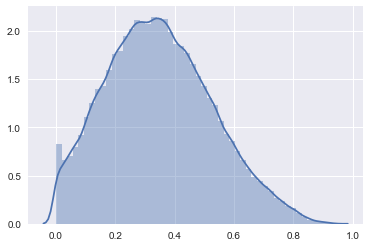

In [265]:
# distribution is normal?? Really weird for this dataset
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [268]:
thresh = .65
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

25034
             precision    recall  f1-score   support

          0     0.9552    0.9522    0.9537    408955
          1     0.2196    0.2313    0.2253     23770

avg / total     0.9148    0.9126    0.9137    432725



In [271]:
param_grid = {'n_estimators': [50, 100, 150], 
              'max_features':  ['auto', 'log2', .5], 
              'min_samples_split': [100, 200, 300], 
              'max_depth': [None, 5, 10], 
              'criterion': ["gini", "entropy"]}
rfc = RandomForestClassifier(n_jobs=-1, oob_score=True)
cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid)
cv_rfc.fit(model_train[features], model_train['broke_from_party'])
cv_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.5,
 'min_samples_split': 100,
 'n_estimators': 100}

In [272]:
rfc = RandomForestClassifier(criterion = 'entropy', 
                             max_depth = None,
                             max_features = 0.5,
                             min_samples_split = 100,
                             n_estimators = 100)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


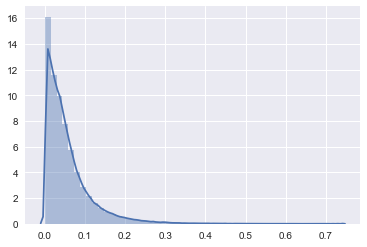

In [273]:
# distribution is normal?? Really weird for this dataset
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [279]:
thresh = .165
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

23580
             precision    recall  f1-score   support

          0     0.9574    0.9578    0.9576    408955
          1     0.2685    0.2663    0.2674     23770

avg / total     0.9195    0.9198    0.9197    432725



In [280]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/districts/geo_rfc_gs.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'district_geo', predictors=features)